In [1]:
import numpy as np 
import matplotlib.pyplot as plt

!pip install pycuda # install pycuda
import pycuda.driver as drv
from pycuda.compiler import SourceModule

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 22 11:28:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

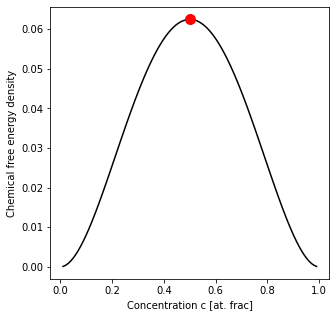

In [3]:
nx = ny = 1024
dx = dy = 1.0
total_step = 500
dt = 0.01
A = 2.0
mobility = 1.0
grad_coef = 1.0
c0 = 0.5

fig = plt.figure(figsize=(5,5))
cc = np.linspace(0.01, 0.99, 100);
plt.plot(cc, cc**2*(1.-cc)**2 ,color='black')
plt.plot(c0, c0**2*(1.-c0)**2 ,color='r',marker='o',markersize=10)
plt.xlabel('Concentration c [at. frac]')
plt.ylabel('Chemical free energy density')
plt.show()

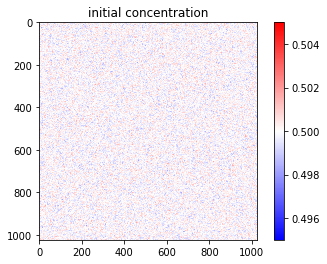

In [4]:
con = np.zeros([nx, ny])
con_new = np.zeros([nx, ny])

#c = c0 + np.random.rand(nx, ny)*0.01
for i in range(nx):
    for j in range(ny):
      con[i,j] = c0 + 0.01 * (0.5 - np.random.rand(1))
plt.imshow(con, cmap='bwr')
plt.title('initial concentration')
plt.colorbar()
plt.show()

## **Define "Device code" to solve Cahn-Hilliard equation**

In [5]:
# CUDA Cで記述する
def get_kernel_string(nx, ny, dx, dy, A, grad_coef, mobility, dt):
    return """
    #include <math.h>
    #define nx %d
    #define ny %d
    #define dx %lf
    #define dy %lf
    #define A  %lf 
    #define grad_coef %lf
    #define mobility %lf
    #define dt %lf
    __global__ void diffuse_kernel(double *u_new, double *u) {

        int i = blockIdx.x * block_size_x + threadIdx.x;
        int j = blockIdx.y * block_size_y + threadIdx.y;

        int ip = i + 1;
        int im = i - 1;
        int jp = j + 1;
        int jm = j - 1;
        int ipp = i + 2;
        int imm = i - 2;
        int jpp = j + 2;
        int jmm = j - 2;

        if(ip > nx-1) {ip = ip - nx;}
        if(im < 0) {im = im + nx;}
        if(jp > ny-1) {jp = jp - ny;}
        if(jm < 0) {jm = jm + ny;}
        if(ipp > nx-1) {ipp = ipp - nx;}
        if(imm < 0) {imm = imm + nx;}
        if(jpp > ny-1) {jpp = jpp - ny;}
        if(jmm < 0) {jmm = jmm + ny;}
            
        double cc = u[j*nx+i];
        double ce = u[j*nx+ip];
        double cw = u[j*nx+im];
        double cs = u[jm*nx+i];
        double cn = u[jp*nx+i];
        double cse = u[jm*nx+ip];
        double cne = u[jp*nx+ip];
        double csw = u[jm*nx+im];
        double cnw = u[jp*nx+im];
        double cee = u[j*nx+ipp];
        double cww = u[j*nx+imm];
        double css = u[jmm*nx+i];
        double cnn = u[jpp*nx+i];

        // chemical term of the diffusion potential
        double mu_chem_c = 2.*A*cc*(1.-cc)*(1.-cc) - 2.*A*cc*cc*(1.-cc);
        double mu_chem_w = 2.*A*cw*(1.-cw)*(1.-cw) - 2.*A*cw*cw*(1.-cw);  
        double mu_chem_e = 2.*A*ce*(1.-ce)*(1.-ce) - 2.*A*ce*ce*(1.-ce); 
        double mu_chem_n = 2.*A*cn*(1.-cn)*(1.-cn) - 2.*A*cn*cn*(1.-cn); 
        double mu_chem_s = 2.*A*cs*(1.-cs)*(1.-cs) - 2.*A*cs*cs*(1.-cs);  

        // gradient term of the diffusion potential
        double mu_grad_c = -grad_coef*( (ce - 2.0*cc + cw)/dx/dx + (cn  - 2.0*cc + cs)/dy/dy);
        double mu_grad_w = -grad_coef*( (cc - 2.0*cw + cww)/dx/dx + (cnw - 2.0*cw + csw)/dy/dy);
        double mu_grad_e = -grad_coef*( (cee - 2.0*ce + cc)/dx/dx + (cne - 2.0*ce + cse)/dy/dy);  
        double mu_grad_n = -grad_coef*( (cne - 2.0*cn + cnw)/dx/dx + (cnn - 2.0*cn + cc)/dy/dy); 
        double mu_grad_s = -grad_coef*( (cse - 2.0*cs + csw)/dx/dx + (cc  - 2.0*cs + css)/dy/dy);             
        
        // total diffusion potental
        double mu_c = mu_chem_c + mu_grad_c; 
        double mu_w = mu_chem_w + mu_grad_w; 
        double mu_e = mu_chem_e + mu_grad_e; 
        double mu_n = mu_chem_n + mu_grad_n; 
        double mu_s = mu_chem_s + mu_grad_s;
       
        // right-hand side of Cahn-Hilliard equation
        double laplace_mu = (mu_w - 2.0*mu_c + mu_e)/dx/dx + (mu_n - 2.0 *mu_c + mu_s)/dy/dy; 
        
        // update order parameter c 
        u_new[j*nx+i] = u[j*nx+i] + mobility*laplace_mu*dt; 
    }
    """ % (nx, ny, dx, dy, A, grad_coef, mobility, dt)

kernel_string = get_kernel_string(nx, ny, dx, dy, A, grad_coef, mobility, dt)

## **Allocate device memory, data transfer, and execute device codes**

It takes  29.795167922973633 ms.


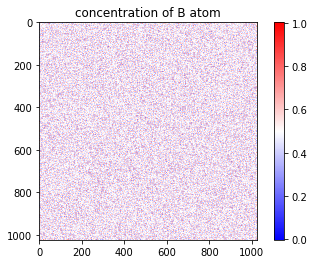

In [6]:
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#allocate GPU memory
u_old = drv.mem_alloc(con.nbytes)
u_new = drv.mem_alloc(con_new.nbytes)

#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)

block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"
diffuse_kernel = SourceModule(block_size_string+kernel_string, arch='sm_'+cc).get_function("diffuse_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data from the Host (CPU) memory to the Device (GPU) memory
drv.memcpy_htod(u_old, con)
drv.memcpy_htod(u_new, con)

#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(total_step):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print("It takes ", end.time_since(start), "ms.")

#copy the result data from the Device (GPU) to the Host (CPU) for plotting
gpu_result = np.zeros_like(con)
drv.memcpy_dtoh(gpu_result, u_new)
    
plt.imshow(gpu_result, cmap='bwr')
plt.title('concentration of B atom')
plt.colorbar()
plt.show() 